# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

**Download Dataset**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yhzang32/dno4pdes")

print("Path to dataset files:", path)

c:\Users\denni\miniconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\denni\.cache\kagglehub\datasets\yhzang32\dno4pdes\versions\8


**Fetch training and testing dataset**

In [6]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32
######################################
# Load training data
######################################
conductivity_dataset = os.path.join(path, 'EffectiveConductivity.h5')
with h5py.File(conductivity_dataset, 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


**Training Data Visualization**

The shape of k_train after flattening: torch.Size([1000, 1296])
The shape of T_train after flattening: torch.Size([1000, 1296])
The shape of x_train: torch.Size([1296, 2])


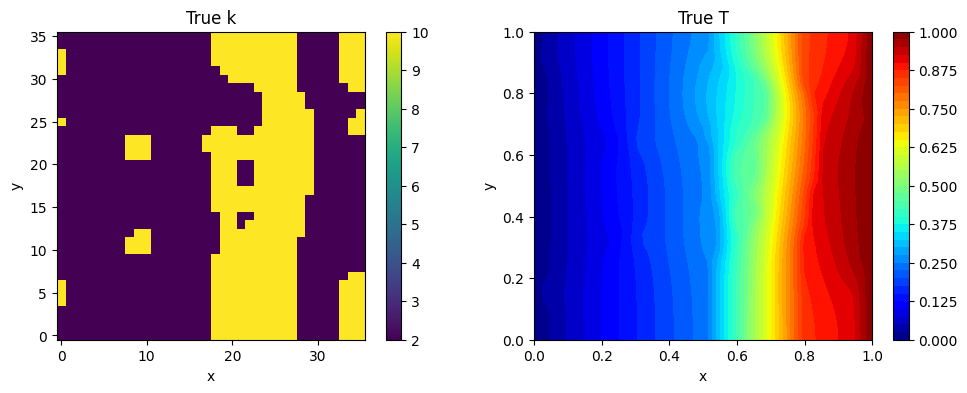

In [7]:
####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#

ndata = k_train.shape[0]
nx, ny = k_train.shape[1], k_train.shape[2]

# flatten the input and output fields
k_train = k_train.reshape(ndata, nx*ny)
T_train = T_train.reshape(ndata, nx*ny)
print('The shape of k_train after flattening:', k_train.shape)
print('The shape of T_train after flattening:', T_train.shape)

# flatten the coordinate grid
x_train = torch.stack([X.flatten(), Y.flatten()], dim=1)
print('The shape of x_train:', x_train.shape)

plt.show()

**DeepONet Model Architecture**

In [44]:
import torch.nn as nn
#
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.SiLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.SiLU()
        if branch_type=='cnn':
            self.branch_net_cnn(layers_branch)
        else:
            self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)

    def branch_net_cnn(self, layers_branch):
        '''The branch network (CNN network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Conv2d(hidden_in, hidden, kernel_size=(5,5), 
                                 stride=2, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in =  hidden 
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, x, k):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            k: size(batch_size, k_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.trunk(x)
        # size(batch_size, k_size) -> size(batch_size, p)
        b = self.branch(k)
        #
        output = torch.einsum("bp,mp->bm", b, t) + self.bias
        return output
#
layers_trunk = [x_train.shape[-1], 128, 128, 128, 128]
layers_branch = [k_train.shape[-1], 128, 128, 128, 128]
#
model_T = DeepONet(layers_trunk, layers_branch).to(device)

**Loss Function Definition**

In [45]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        # self.getLoss = torch.nn.MSELoss()
    
    def loss_data(self, k_batch, T_batch):
        '''loss term'''
        x, k, T = x_train.to(self.device), k_batch.to(self.device), T_batch.to(self.device)
        #
        T_pred = self.u_model(x, k)
        loss = torch.norm(T-T_pred, 2, 1)
        loss = torch.mean(loss)
        # loss = self.getLoss(u, u_pred)
        
        return loss 

**Dataloader Set Up**

In [46]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, k:torch.tensor, T:torch.tensor):
        '''
        Input:
            k: size(batch_size, a_size)
            T: size(batch_size, u_size)
        '''
        self.k = k 
        self.T = T
    
    def __getitem__(self, index):
        return self.k[index], self.T[index]

    def __len__(self):
        return self.k.shape[0]
        
##############
train_loader = DataLoader(MyDataset(k_train, T_train), batch_size=50, shuffle=True)
for k_batch, T_batch in train_loader:
    print('k_batch shape:', k_batch.shape, 'T_batch shape:', T_batch.shape)

k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shape: torch.Size([50, 1296]) T_batch shape: torch.Size([50, 1296])
k_batch shap

**Model Training & Saving**

In [ ]:
from tqdm import trange
import time
############ Training setups
epochs = 10000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_T.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/8), gamma=0.5)
loss_list = []
############ The training process
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for k_batch, T_batch in train_loader:
        lossClass = LossClass(model_T)
        loss_train = lossClass.loss_data(k_batch, T_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%2000==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

torch.save(model_T.state_dict(), 'model_T.pth')
print("Model weights saved successfully.")

 20%|██        | 2001/10000 [03:10<11:25, 11.66it/s]

Epoch:1999, The loss is:0.36660054326057434


 40%|████      | 4002/10000 [06:32<09:22, 10.66it/s]

Epoch:3999, The loss is:0.32381904125213623


 60%|██████    | 6001/10000 [09:34<05:47, 11.51it/s]

Epoch:5999, The loss is:0.30847182869911194


 80%|████████  | 8001/10000 [11:56<02:25, 13.72it/s]

Epoch:7999, The loss is:0.30068832635879517


100%|██████████| 10000/10000 [14:40<00:00, 11.36it/s]

Epoch:9999, The loss is:0.2983352839946747
The consuming time is: 880.1659035682678
Model weights saved successfully.


**Plotting Results**

The average l2 error: tensor(0.0337)


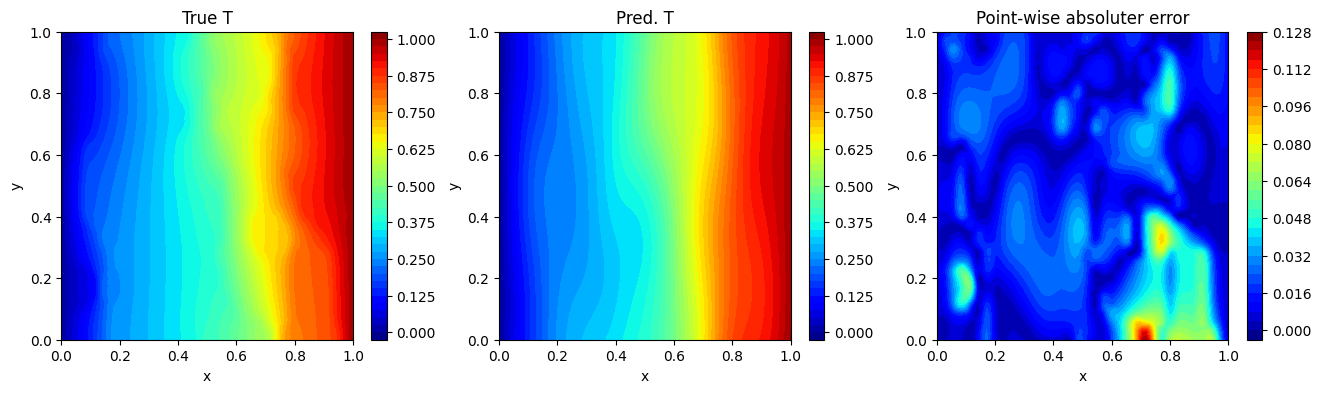

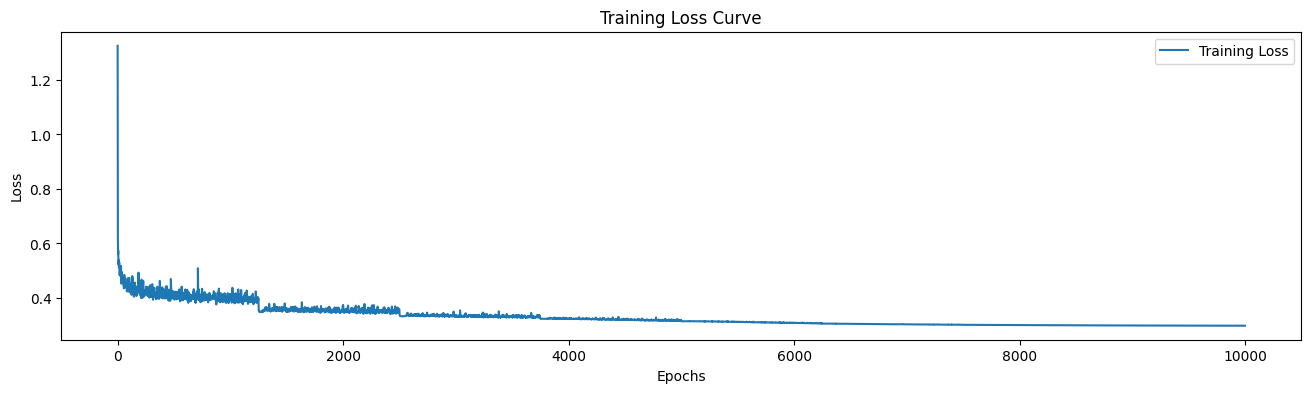

In [59]:
import warnings
warnings.filterwarnings("ignore")

x_test = x_train
k_test = k_test.reshape(k_test.shape[0], -1)
T_test = T_test.reshape(T_test.shape[0], -1)

#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred):
    ''' '''
    l2 = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)
    return l2
# Make prediction with trained model
T_test_pred = model_T(x_test.to(device), k_test.to(device)).detach().cpu()
# compute the L2 relative error
l2_err = L2_error(T_test, T_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
T_true, T_pred = T_test[0], T_test_pred[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
#
points = x_train.cpu().numpy()
z_plot = griddata(points, np.ravel(T_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True T')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata(points, np.ravel(T_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata(points, np.ravel(np.abs(T_true-T_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')

fig = plt.figure(figsize=(16, 4))
plt.plot(np.arange(epochs), loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.show()